# Consistency: 
An XAI will produce similar explanations for similarly performing predictors

In [1]:
import subprocess
import sys
import numpy as np
from numpy import mean
from numpy import var
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from scipy.stats.stats import pearsonr 
from scipy.spatial import distance
from sklearn import metrics
import pickle
from collections import Counter
%matplotlib inline


In [2]:
def sort_pos(ls):
    ls_dict = {k:v for v,k in enumerate(ls)}
    sorted_ls = sorted(ls,reverse=True)
    return [ls_dict[k] for k in sorted_ls]


def average_random_dist(ground,mutable,n=100):
    d = distance.euclidean(ground,mutable)
    dist = 0 

    for i in range(n):
        np.random.shuffle(mutable)
        dist = dist + distance.euclidean(ground,mutable)   
    return dist/n

# function to calculate Cohen's d for independent samples

def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [3]:
# random idx
idx_dict = {}

for hla in ['HLAA0201','HLAA2403','HLAA3201','HLAB0702','HLAB3901','HLAB1517','HLAC0602','HLAC1402','HLAC1502']:
    print(hla)
    path_mhcflurry = './example/raw_data/'+hla+'_SHAP_MHCFlurry.pkl' # or LIME_MHCFlurry.pkl
    df_mhcflurry = np.array(pd.read_pickle(path_mhcflurry))
    np.random.seed(seed=0)
    idx = np.random.choice(len(df_mhcflurry), 200, replace=False)
    idx_dict[hla] = idx
    
pd.DataFrame(idx_dict).to_csv('./data/consistency/idx.csv')


HLAA0201
HLAA2403
HLAA3201
HLAB0702
HLAB3901
HLAB1517
HLAC0602
HLAC1402
HLAC1502


In [6]:
corr_shap = []
dist_shap = []
pval_kruskal_shap = []
pval_allele_shap = []
H_allele_shap = []
cohend_allele_shap = []
dict_corr_shap = {}

for hla in ['HLAA0201','HLAA2403','HLAA3201','HLAB0702','HLAB3901','HLAB1517','HLAC0602','HLAC1402','HLAC1502']:
    print(hla)
    
    path_mhcfovea = './example/raw_data/'+hla+'_SHAP_MHCFovea.pkl'
    path_mhcflurry = './example/raw_data/'+hla+'_SHAP_MHCFlurry.pkl'
    
    df_mhcflurry = np.array(pd.read_pickle(path_mhcflurry))
    df_mhcfovea = np.array(pd.read_pickle(path_mhcfovea))
    
    idx_dict = pd.read_csv('./data/consistency/idx.csv',index_col=0)
    idx = list(idx_dict[hla])
    
    df_mhcflurry = df_mhcflurry[idx,:]
    df_mhcfovea = df_mhcfovea[idx,:]
    
    print(len(df_mhcflurry))
    corr_shap = corr_shap + [np.corrcoef(a,b)[0][1] for a,b in zip(df_mhcflurry,df_mhcfovea)]    
    dict_corr_shap[hla] = [np.corrcoef(a,b)[0][1] for a,b in zip(df_mhcflurry,df_mhcfovea)]
    pval_kruskal_shap = pval_kruskal_shap + [stats.kruskal(a,b)[1] for a,b in zip(df_mhcflurry,df_mhcfovea)]
    H_kruskal_shap = pval_kruskal_shap + [stats.kruskal(a,b)[0] for a,b in zip(df_mhcflurry,df_mhcfovea)]
    
    d1 = [distance.euclidean(a,b) for a,b in zip(df_mhcflurry,df_mhcfovea)]
    d2 = [average_random_dist(a,b) for a,b in zip(df_mhcflurry,df_mhcfovea)]
    dist_shap = dist_shap + d1
    
    c_tmp = 0
    for a,b in zip(d1,d2):
        if a>b:
            c_tmp = c_tmp + 1
    print('count when average random distance is lower than explanations between two similar predictors: ',c_tmp)
    # This is important to establish significance that similar explanations are closer than random explanations
    # The lower the count i.e. number of times random distance is lower than similar explanation is better
        
    pval_allele_shap = pval_allele_shap + [stats.kruskal(d1,d2)[1]]
    H_allele_shap = H_allele_shap + [stats.kruskal(d1,d2)[0]]
    cohend_allele_shap = cohend_allele_shap + [cohend(d1,d2)]
    
pd.DataFrame(dict_corr_shap).to_csv('./data/consistency/results/Pearr_consistency_shap.csv')

HLAA0201
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAA2403
200
count when average random distance is lower than explanations between two similar predictors:  2
HLAA3201
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAB0702
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAB3901
200
count when average random distance is lower than explanations between two similar predictors:  1
HLAB1517
200
count when average random distance is lower than explanations between two similar predictors:  1
HLAC0602
200
count when average random distance is lower than explanations between two similar predictors:  1
HLAC1402
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAC1502
200
count when average random distance is lower than explanations between two similar predictors:  0


In [7]:
pval_allele_shap, H_allele_shap, cohend_allele_shap

([8.378193377701596e-25,
  1.4446287839765909e-18,
  6.732323688824222e-34,
  2.5881975327352527e-33,
  7.760115004295539e-10,
  7.223724321479274e-26,
  5.418635112119602e-40,
  1.873204288371045e-56,
  1.1834569067495786e-39],
 [105.74687356608479,
  77.33258528678289,
  147.30450673316682,
  144.6293386533664,
  37.81952618453852,
  110.60444962593488,
  175.19836084788017,
  250.65068528678262,
  173.6448067331669],
 [-1.3733290306682884,
  -0.9462241123055741,
  -1.6127738447450326,
  -1.442841701564093,
  -0.738160881984383,
  -1.1846918300924567,
  -1.7128129948228947,
  -2.209947662914579,
  -1.8896394640310932])

In [8]:
corr_lime = []
dist_lime = []
pval_kruskal_lime = []
pval_allele_lime = []
H_allele_lime = []
cohend_allele_lime = []
dict_lime = {}
dict_corr_lime = {}

for hla in ['HLAA0201','HLAA2403','HLAA3201','HLAB0702','HLAB3901','HLAB1517','HLAC0602','HLAC1402','HLAC1502']:
    print(hla)
    path_mhcfovea = './example/raw_data/'+hla+'_LIME_MHCFovea.pkl'
    path_mhcflurry = './example/raw_data/'+hla+'_LIME_MHCFlurry.pkl'

    df_mhcflurry = np.array(pd.read_pickle(path_mhcflurry))
    df_mhcfovea = np.array(pd.read_pickle(path_mhcfovea))
    
    idx_dict = pd.read_csv('./data/consistency/idx.csv',index_col=0)
    idx = list(idx_dict[hla])
    
    df_mhcflurry = df_mhcflurry[idx,:]
    df_mhcfovea = df_mhcfovea[idx,:]
    print(len(df_mhcflurry))
    
    corr_lime = corr_lime + [np.corrcoef(a[1:10],b[1:10])[0][1] for a,b in zip(df_mhcflurry,df_mhcfovea)]
    dict_corr_lime[hla] = [np.corrcoef(a[1:10],b[1:10])[0][1] for a,b in zip(df_mhcflurry,df_mhcfovea)]
    pval_kruskal_lime = pval_kruskal_lime + [stats.kruskal(a[1:10],b[1:10])[1] for a,b in zip(df_mhcflurry,df_mhcfovea)]
    
    d1 = [distance.euclidean(a[1:10], b[1:10]) for a,b in zip(df_mhcflurry,df_mhcfovea)]
    d2 = [average_random_dist(a[1:10],b[1:10]) for a,b in zip(df_mhcflurry,df_mhcfovea)]
    dist_lime = dist_lime + d1
    
    c_tmp = 0
    for a,b in zip(d1,d2):
        if a>b:
            c_tmp = c_tmp + 1
    print('count when average random distance is lower than explanations between two similar predictors: ',c_tmp)
    # This is important to establish significance that similar explanations are closer than random explanations
    # The lower the count i.e. number of times random distance is lower than similar explanation is better
    
    pval_allele_lime = pval_allele_lime + [stats.kruskal(d1,d2)[1]]
    H_allele_lime = H_allele_lime + [stats.kruskal(d1,d2)[0]]
    cohend_allele_lime = cohend_allele_lime + [cohend(d1,d2)]
    
pd.DataFrame(dict_corr_lime).to_csv('./data/consistency/results/Pearr_consistency_lime.csv')

HLAA0201
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAA2403
200
count when average random distance is lower than explanations between two similar predictors:  1
HLAA3201
200
count when average random distance is lower than explanations between two similar predictors:  1
HLAB0702
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAB3901
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAB1517
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAC0602
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAC1402
200
count when average random distance is lower than explanations between two similar predictors:  0
HLAC1502
200
count when average random distance is lower than explanations between two similar predictors:  0


In [16]:
pval_allele_lime, H_allele_lime, cohend_allele_lime

([1.3688408184642e-66,
  3.650339031987555e-32,
  6.0146227142063955e-50,
  7.668768643543704e-58,
  2.988138950532946e-56,
  5.968365466914568e-58,
  7.555446037653798e-60,
  2.258894528814384e-62,
  1.9886056279830366e-60],
 [297.16077306733155,
  139.37296832917718,
  220.81226932668324,
  257.0171259351621,
  249.72037406483787,
  257.51656533665846,
  266.2223162094763,
  277.8051620947631,
  268.8821177057357],
 [-2.893325358207902,
  -1.1942135742337079,
  -1.742524413229311,
  -1.4041825566776824,
  -1.5983776655318027,
  -2.12925242165817,
  -2.5280128391268817,
  -2.6664105638262963,
  -2.6531457537608407])

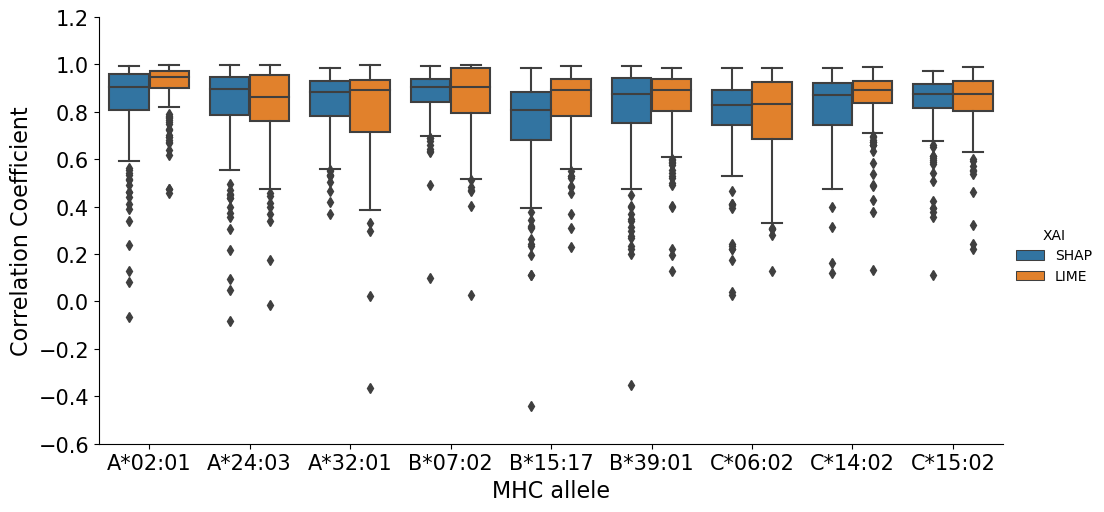

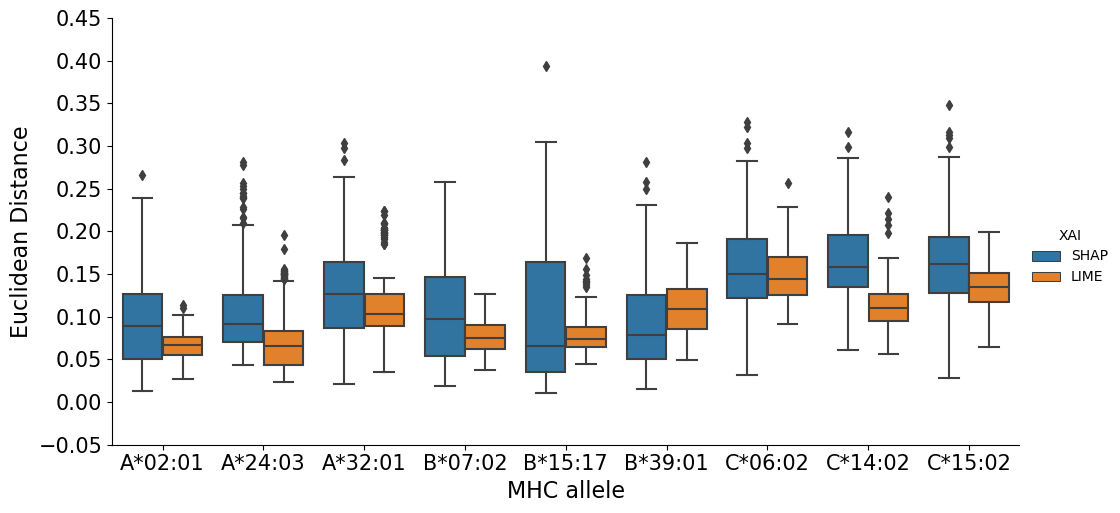

In [18]:
hla_list = ['A*02:01']*200 + ['A*24:03']*200 + ['A*32:01']*200 +\
           ['B*07:02']*200 + ['B*15:17']*200 + ['B*39:01']*200 +\
           ['C*06:02']*200 + ['C*14:02']*200 + ['C*15:02']*200


xai = ['SHAP']*len(hla_list) + ['LIME']*len(hla_list)

hla_list = hla_list + hla_list

corr = corr_shap + corr_lime

b = sns.catplot(data=pd.DataFrame({'corr':corr,'hlas':hla_list,'XAI':xai}),
                y='corr',x='hlas',hue='XAI', kind='box', height=5,aspect=2)

b.set_ylabels('Correlation Coefficient',size=16)
b.set_xlabels('MHC allele',size=16)
b.set_yticklabels(size = 15)
b.set_xticklabels(size = 15)
plt.show()

dist = dist_shap + dist_lime

b = sns.catplot(data=pd.DataFrame({'dist':dist,'hlas':hla_list,'XAI':xai}),
                y='dist',x='hlas',hue='XAI', kind='box',height=5,aspect=2)

b.set_ylabels('Euclidean Distance',size=16)
b.set_xlabels('MHC allele',size=16)
b.set_yticklabels(size = 15)
b.set_xticklabels(size = 15)
plt.show()